# 多分类问题(石头剪刀布)
主要参考于[DeepLearning.ai课程](https://github.com/lmoroney/dlaicourse/blob/master/Course%202%20-%20Part%208%20-%20Lesson%202%20-%20Notebook%20(RockPaperScissors).ipynb)

在此前，我们通过构建卷积神经网络解决识别人马分类问题和猫狗问题，这些都是经典的二分类问题，这次我们来解决一个多分类问题：识别石头剪刀布。

## 1. 数据准备

In [10]:
import os
import zipfile

local_zip = 'tmp/rps.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('tmp/')
zip_ref.close()


local_zip = 'tmp/rps-test-set.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/')
zip_ref.close()

In [11]:
rock_dir = os.path.join('tmp/rps/rock')
print(rock_dir)
paper_dir = os.path.join('tmp/rps/paper')
scissors_dir = os.path.join('tmp/rps/scissors')

print('total training rock images:', len(os.listdir('tmp/rps/rock')))
print('total training paper images:', len(os.listdir(paper_dir)))
print('total training scissors images:', len(os.listdir(scissors_dir)))

rock_files = os.listdir(rock_dir)
print(rock_files[:10])

paper_files = os.listdir(paper_dir)
print(paper_files[:10])

scissors_files = os.listdir(scissors_dir)
print(scissors_files[:10])

tmp/rps/rock
total training rock images: 840
total training paper images: 840
total training scissors images: 840
['rock01-000.png', 'rock01-001.png', 'rock01-002.png', 'rock01-003.png', 'rock01-004.png', 'rock01-005.png', 'rock01-006.png', 'rock01-007.png', 'rock01-008.png', 'rock01-009.png']
['paper01-000.png', 'paper01-001.png', 'paper01-002.png', 'paper01-003.png', 'paper01-004.png', 'paper01-005.png', 'paper01-006.png', 'paper01-007.png', 'paper01-008.png', 'paper01-009.png']
['scissors01-000.png', 'scissors01-001.png', 'scissors01-002.png', 'scissors01-003.png', 'scissors01-004.png', 'scissors01-005.png', 'scissors01-006.png', 'scissors01-007.png', 'scissors01-008.png', 'scissors01-009.png']


tmp/rps/rock\rock01-000.png


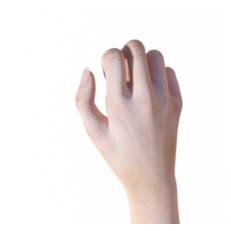

tmp/rps/rock\rock01-001.png


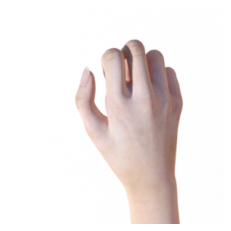

tmp/rps/paper\paper01-000.png


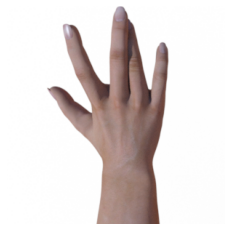

tmp/rps/paper\paper01-001.png


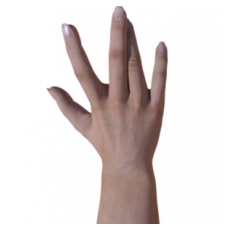

tmp/rps/scissors\scissors01-000.png


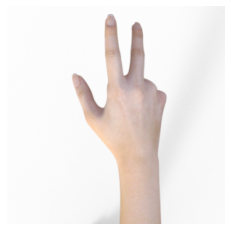

tmp/rps/scissors\scissors01-001.png


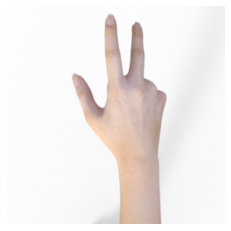

In [13]:
# 显示数据
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 2

next_rock = [os.path.join(rock_dir, fname) 
                for fname in rock_files[pic_index-2:pic_index]]
next_paper = [os.path.join(paper_dir, fname) 
                for fname in paper_files[pic_index-2:pic_index]]
next_scissors = [os.path.join(scissors_dir, fname) 
                for fname in scissors_files[pic_index-2:pic_index]]

for i, img_path in enumerate(next_rock+next_paper+next_scissors):
  print(img_path)
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

## 2. 构建并训练模型

In [14]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

TRAINING_DIR = "tmp/rps/"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

VALIDATION_DIR = "tmp/rps-test-set/"
validation_datagen = ImageDataGenerator(rescale = 1./255)


# 由于是多类别，所以使用：categorical
train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(150,150),
    class_mode='categorical',
  batch_size=126
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(150,150),
    class_mode='categorical',
  batch_size=126
)

model = tf.keras.models.Sequential([
    # 注意输入的大小！
    # 第一层卷积层
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    # 第二层卷积层
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    # 第三层卷积层
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    # 第四层卷积层
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #展平数据并且输入到DNN中
    tf.keras.layers.Flatten(),
    # 防止过拟合使用Dropout正则化
    tf.keras.layers.Dropout(0.5),
    # 第五层
    tf.keras.layers.Dense(512, activation='relu'),
    # 第六层
    tf.keras.layers.Dense(3, activation='softmax')
])


model.summary()

# 由于是多分类，使用：categorical_crossentropy
model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model.fit(train_generator,
                    epochs=25, 
                    steps_per_epoch=20,
                    validation_data = validation_generator,
                    verbose = 1, 
                    validation_steps=3)

# 将训练得到的参数存储下来
model.save("rps.h5")

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_______________________________________

## 3. 可视化损失和精确度

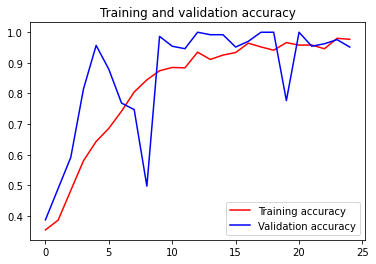

<Figure size 432x288 with 0 Axes>

In [15]:

import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

## 4. 用自己的图片测试模型

In [16]:
import numpy as np
from keras.preprocessing import image

fn = 'myimage/4.jpg'
path = 'tmp/' + fn
img = image.load_img(path, target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)


images = np.vstack([x])
classes = model.predict(images, batch_size=10)
print(classes[0])


Using TensorFlow backend.


[0. 0. 1.]
